### This is a notebook to show use of the python code supporting this publication

In [5]:
#import modules
import pandas as pd # pandas is used for manipulating data sets
import numpy as np # numpy is used for working with arrays

import plotly
import plotly.graph_objects as go # plotly graph objects used for plots
from plotly.subplots import make_subplots # plotly subplots
import plotly.express as px # plotly express used for color palettes

import rdkit
from rdkit import Chem # import packages from RDKit for drawing molecules based on their SMILES code
from rdkit.Chem import Draw

In [6]:
print(pd.__version__)
print(np.__version__)
print(rdkit.__version__)
print(plotly.__version__)

1.5.3
1.26.0
2022.03.5
5.17.0


### Define calculation functions

In [31]:
def GetCompoundData(name, pka_values):
    '''This is a function that extracts compound data from a df with pka data.
        It takes a string as the compound name and a df with the data. It slices the df to find the compound
        data and manipulates it to calculate the number of forms, which is the neutral form, and their pKas.
        It returns these three values.'''

    # use the name to slice the data
    pka_data = pka_values.loc[pka_values['AZ_numbers'] == name]

    acd_acids = [value for value in pka_data.iloc[:, 4:8].values[0] if not pd.isnull(value)]
    acd_bases = [value for value in pka_data.iloc[:, 0:4].values[0] if not pd.isnull(value)]

    # find out which is the neutral form
    if len(acd_bases) > 0:  # make sure that the compound can behave as a base at low pH and has an exp base value
        neutral_form = len(acd_bases) + 1  # neutral form is the one after all the deprotonated forms

    else:
        neutral_form = 1  # if only acidic forms, then neutral form is the first one

    pkas = acd_bases
    pkas.extend(acd_acids)

    pkas.sort()  # sort the values in ascending order

    no_of_forms = len(pkas) + 1  # the no. of forms is the number of pka values +1

    return no_of_forms, pkas, neutral_form

# define function to update compound dictionary with values
def RetrieveCompoundPhysChem(compound, pka_values):
    ''' This is a function to update a compound dictionary with corresponding physchem data.
        It takes a compound dictionary and a df with pka values, and returns an
        updated compound dictionary object. '''

    # get name and physchem data
    name = compound.get('Name').lower().title()
    physchem_values = GetCompoundData(name, pka_values)

    forms = []  # create empty list for forms

    form = 0  # set counter to 0
    neutral_form = physchem_values[2]  # get neutral form

    while form < (physchem_values[0]):  # loop runs while counter < number of forms
        if (form + 1) == neutral_form:  #
            forms.append(f'{name} (neutral form)')
        else:
            charge = neutral_form - (
                    form + 1)  # calculates charge based on distance from neutral form
            if charge > 0:
                charge = (f'+{charge}')  # if charge positive, add a '+' infront
            forms.append(f'{name} (q= {charge})')
        form += 1  # add one to the counter

    # update the compound dictionary
    compound['pka_data'] = True
    compound.update({'Forms': forms,
                     'pka_values': physchem_values[1],
                     'Kas': [10 ** -pka for pka in physchem_values[1]] if physchem_values[
                         1] else [],  # 10 ** -35,  # to handle compounds which remain neutral
                     'Neutral Form': physchem_values[2],
                     'Extraction': f'Extraction of {name} [Form {physchem_values[2]}]'
                     })

    return compound

# define function to get SMILES and chemical structures
def RetrieveSmilesToMol(compound, structures):
    ''' This is a function to update a compound dictionary with mol objects to visualise molecules.
        It takes a compound dictionary and a df with SMILES and returns the updated compound dictionary object. '''

    # use compound name to identify smiles structure
    name = compound.get('Name').lower().title()
    smi = structures.loc[structures['COMPOUND_NAME'] == name, 'SMILES_ISOMERIC'].values[0]

    # update dictionary
    compound.update({'Structure': Chem.MolFromSmiles(smi)})

    return compound


# define function to get the species list
def SpeciesList(compound):
    ''' This is a function to construct a list with the species mole fractions.
        It takes a compound dictionary and returns a list with the mole fraction of
        each form at each pH.'''

    ph = np.arange(0.0, 14.1, 0.1)  # get the pH range
    conc_H = 10 ** -ph  # calculate concentration of protons over the ph range
    speciation_terms = [np.ones_like(ph)]  # first form speciation is 1 - needed for calculation

    for ind, Ka in enumerate(compound['Kas']): # enumerate Kas to get position and value of each Ka
        # calculate speciation term from cumulative product of Kas, divided by concentration to the power of (ind+1)
        speciation_term = np.prod(compound['Kas'][:ind + 1]) / conc_H ** (ind + 1)
        speciation_terms.append(speciation_term) # append new term to list

    # get the sum of terms for below calculation
    speciation_sum = sum(speciation_terms)

    # get the species counts at each ph (fraction of each species / total)
    species = [term / speciation_sum for term in speciation_terms]

    return species


# define speciation terms df
def SpeciesDf(compound):
    ''' This is a function to construct a dataframe with the species mole fractions.
        It takes a compound dictionary and returns a dataframe.'''

    sp = SpeciesList(compound) # get species

    # constuct the df
    species_df = pd.DataFrame(sp, index=compound['Forms']).T  # .T allows transposition of df, turns rows into columns and vice versa

    return species_df


# define extraction in aqueous layer
def AqueousExtractionFraction(compound):
    ''' This is a function to calculate the mole fraction of the compound in the aqueous layer.
        It takes a compound dictionary as an argument and returns a list with the mole fraction of
        each form in the aqueous layer'''

    # retrieve the speciations again
    species = SpeciesList(compound)

    # use list comprehension to get the aqueous extracts of each form
    aq_extractions = [1 / (1 + (compound['Kp'] * compound.get('Vr') * sp)) for sp in species]

    return aq_extractions


# define extraction in organic layers
def OrganicExtractionFraction(compound):
    ''' This is a function to calculate the mole fraction of the compound in the organic layer.
        It takes a compound dictionary as an argument and returns a list with the mole fraction of
        each form in the organic layer'''

    # retrieve the speciations again
    aqueous_extracts = AqueousExtractionFraction(compound)

    # use list comprehension to get the org extracts for each form (1 - aq)
    org_extractions = [1 - aq_extract for aq_extract in aqueous_extracts]

    return org_extractions


# define function to get fraction extracted for each compound
def FractionExtracted(compound, system):
    # change to fraction extracted
    ''' This is a function to calculate the fraction extracted of each compound in its neutral form.
    It returns a df with the fraction extracted of the isolate in the desired phase
    and the fraction extracted of the impurity in the opposite phase (for each pH).'''

    # for aqueous system
    if system['Extraction Phase'] == 'Aqueous':

        # get extraction efficiency for compound in neutral form in aq phase
        extract = AqueousExtractionFraction(compound)[compound.get('Neutral Form') - 1]

        if compound['Isolate'] == True:
            raw_efficiency = extract  # if isolate, efficiency stays the same
        else:
            raw_efficiency = 1 - extract # if impurity, we do 1 - efficiency
            # note that if ratio isn't edited, it is set to 1

    # for organic system
    else:
        # get extraction efficiency for compound in neutral form in org phase
        extract = OrganicExtractionFraction(compound)[compound.get('Neutral Form') - 1]

        if compound['Isolate'] == True:
            raw_efficiency = extract  # if isolate, efficiency stays the same
        else:
            raw_efficiency = 1 - extract # if impurity, we do 1 - efficiency

    return raw_efficiency # return df

# # define a function to get fraction extracted for each compound at a specific pH
def FractionExtractedAtpH(compounds, system, ph):
    # slice fraction extracted for given pH
    ''' This is a function to calculate the fraction extracted for the desired compound in the desired phase
        and the impurities in the rejected phase. It takes a compounds object (dictionary), a system
        object (dictionary), and a pH value, and returns a dictionary of compound names and fraction extracted values. '''

    ph_ = np.arange(0.0, 14.1, 0.1) # get the ph range
    ind_ph = ph_.tolist().index(ph) # get the index of the ph of the extraction
    fractions_extracted = {} # initialise a dictionary to hold the data

    # loop through the compounds
    for compound in compounds.values():
        name = compound['Name'] # get name

        # get the fraction extracted for the compound at the specified pH
        desired_fraction = FractionExtracted(compound, system)[ind_ph]
        fractions_extracted[f'{name}'] = desired_fraction # add entry to dictionary

    return fractions_extracted # return dictionary

# define function to get the extraction efficiency for the isolated compound
def IsolateExtractionEfficiency(compounds, system):
    #isolate extraction efficiency
    ''' This is a function to calculate the isolation efficiency of the desired compound.
        It takes a list of compounds, and a system dictionary as arguments and returns an array
        with the mole fraction of the desired compound extracted into the phase specified by the system. '''

    # initialise empty lists to hold extraction efficiency for each type of compound
    n_main = []
    n_imps = []

    # append raw extraction efficiencies of isolate and impurity compounds to each list
    for compound in compounds.values():
        if compound['Isolate'] == True:
            n_main.append(FractionExtracted(compound, system))

        else:
            n_imps.append(FractionExtracted(compound, system))

    # flattens n_main array into an array containing the sum of the columns
    sum_main = sum(n_main)

    # if there are no impurities, only isolate extraction efficiency * 100
    if len(n_imps) == 0:
        efficiency = 100 * (sum_main)

    else: # if impurities present, calculate mean of impurities
        sum_imps = sum(n_imps) / len(n_imps)
        efficiency = 100 * (sum_main * sum_imps)

    return efficiency

# define function to calculate the extraction efficiency at the extraction pH
def ExtractionEfficiencyAtSystempH(compounds, system):
    '''This is a function to calculate the extraction efficiency of the isolated compound at a the specified
     extraction (aqueous phase) pH. '''

    ph = np.arange(0.0, 14.1, 0.1)  # get the pH range
    aqueous_pH = system['Extraction (Aqueous Phase) pH']  # get the system pH

    # get the extraction efficiency of all compounds in system (isolate * impurities)
    eff = IsolateExtractionEfficiency(compounds, system)

    name = [compound['Name'].lower().title() for compound in compounds.values() if compound['Isolate']][0]  # get isolate name

    # get index value of aq pH
    # ind = ph.tolist().index(aqueous_pH) no longer works
    ind = int(10 * aqueous_pH)
    efficiency_at_ph = eff[ind]  # use it to get the extraction efficiency

    return name, aqueous_pH, efficiency_at_ph


# define function to calculate the maximum Extraction Efficiency independent of pH
def MaximumExtractionEfficiency(compounds, system):
    '''This is a function to calculate the maximum extraction efficiency of the desired compound in an
        extraction system. It takes a compounds object (dictionary) and a system object (dictionary) and
        it returns two values: the pH for the maximum efficiency, and the maximum extraction efficiency.'''

    ph = np.arange(0.0, 14.1, 0.1)  # get the pH range

    # get the extraction efficiency of all compounds in system (isolate * impurities)
    eff_ = IsolateExtractionEfficiency(compounds, system)

    ph_max_eff = ph[np.argmax(eff_)]  # get the pH at the max efficiency
    max_eff = eff_.max()  # get the max efficiency

    return ph_max_eff, max_eff

# function to run exhaustive calculations
def CalculateExhaustiveExtractions(solvents, compounds, system):
    '''This is a function to iterate through every solvent at every pH, where Vr is set to 1.
    (NB: This does not limit results based on org_rel_vol). It takes all solvents and compounds info and returns the
    solvents which are missing logP or solubility data, and a df called full_concat_results.'''

    # initialise empty lists to hold different lists of solvents
    full_logp_available_solvents = []
    full_logp_unavailable_solvents = []
   
    #  empty lists to hold results
    full_results = []

    # try / except loop so there's no error thrown if no results are available
    try:
        # figure out for which of the selected solvents we actually have logP values
        for solvent in solvents['Preferred Name']:
            if solvent in pivoted_solvents.index:
                full_logp_available_solvents.append(solvent)
            else:
                # if no logP values, add solvent to the list of unavailable solvents
                full_logp_unavailable_solvents.append(solvent)

        # set vr = 1 for all compounds
        for compound in compounds.values():
            compound['Vr'] =  1.0

            # get the name of the compound to isolate
            if compound['Isolate'] == True:
                desired = compound['Name'].lower().title()

        # for each available solvent (ignored solvents missing logP data)
        # update logP values then calculate ext eff
        for solvent in full_logp_available_solvents:

            sub_df = pd.DataFrame() # make temporary df to add to

            # make row in temporary df for every solvent at every pH...
            sub_df['pH'] = np.arange(0.0, 14.1, 0.1)
            sub_df['Solvent'] = [solvent for val in sub_df['pH'].values]

            # iterate through compounds and set logPs for that solvent
            for compound in compounds.values():
                name = compound.get('Name').lower().title() # get name

                logp_value = pivoted_solvents.loc[solvent, name]
                compound['Kp'] = 10 ** logp_value

                # add the compound logP value to the sub_df
                sub_df[f'{name}_logP'] = [logp_value for val in sub_df['pH'].values]

            # get extraction efficiency and add new column
            if system_panel_values['Extraction Phase'] == 'Aqueous':
                sub_df[f'Extraction_eff_{desired}_aq'] = IsolateExtractionEfficiency(compounds,
                                                                                     system)
            else:
                sub_df[f'Extraction_eff_{desired}_org'] = IsolateExtractionEfficiency(compounds,
                                                                                      system)

            # iterate through compounds and get fraction extracted
            for compound in compounds.values():
                name = compound.get('Name').lower().title() # get name

                # add columns for fraction extracted for each compound
                # here, we are measuring fraction extracted of the impurities in the DESIRED phase

                if system_panel_values['Extraction Phase'] == 'Aqueous':
                    sub_df[f'Fraction_extracted_{name}_aq'] = AqueousExtractionFraction(compound)[
                        compound.get('Neutral Form') - 1]
                else:
                    sub_df[f'Fraction_extracted_{name}_org'] = OrganicExtractionFraction(compound)[
                        compound.get('Neutral Form') - 1]

            sub_df['Volume_ratio'] = [1.0 for val in sub_df['pH'].values] # make Vr column = 1.0
            # calculate Aq_rel_vol and Total_rel_vol

            full_results.append(sub_df) # append temporary df to results df

        # merging Series and df object to single df and avoid index being added as column
        full_concat_results = pd.concat(full_results).reset_index(drop=True)

        # currently remove .dropna() below as some compound/solvent combos are missing solubility/PMI data
        #full_concat_results = pd.concat(full_results).dropna().reset_index(drop=True)

        # returns lists of solvents missing logP and solvents missing solubility values
        # returns concatenated results df
        return full_logp_unavailable_solvents, full_concat_results

    except ValueError: # if there are no available solvents, there will be no concat results

        # returns lists of solvents missing logP values
        # returns None (in place of results)
        return full_logp_unavailable_solvents,  None


def CalculateExtractions(solvents, compounds, system, volume_ratio):
    '''This is a function to iterate the calculations for every solvent, limited by the user's choice of 
    volume ratio range. It takes all solvents, compounds and volume ratio and returns the solvents which 
    are missing logP data, and a df called concat_results.'''

    # initialise empty lists to hold different lists of solvents
    available_solvents = []
    logp_unavailable_solvents = []

    # empty list to hold results
    results = []

    # try / except loop so that there's no error thrown if no results are available
    try:

        # figure out for which of the selected solvents we actually have logP values
        for solvent in solvents['Preferred Name']:
            if solvent in pivoted_solvents.index:
                available_solvents.append(solvent)
            else:
                # if no logP values, add solvent to the list of unavailable solvents
                logp_unavailable_solvents.append(solvent)

        # get array of possible volume ratios
        vrs = np.array([0.1, 0.2, 0.25, 0.33, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 4.0, 5.0])

        # iterate through Vr range user has selected
        for vr in vrs[(vrs >= volume_ratio[0]) & (vrs <= volume_ratio[1])]:

            # set Vr for all compounds
            for compound in compounds.values():
                compound['Vr'] = vr # set Vr for this iteration (needed in calculations)

                # get the name of the compound to isolate
                if compound['Isolate'] == True:
                    desired = compound['Name'].lower().title()

            # for each available solvent (ignores solvents missing  logP data)
            # update logP values then calculate max ext eff
            for solvent in available_solvents:

                sub_df = pd.DataFrame() # make temporary df to add to

                # iterate through compounds and set logPs for that solvent
                for compound in compounds.values():
                    name = compound.get('Name').lower().title()  # get name

                    # get logP value and set compound Kp (for each solvent)
                    logp_value = pivoted_solvents.loc[solvent, name]
                    compound['Kp'] = 10 ** logp_value

                    # add the compound logP value to the sub_df
                    sub_df.loc[solvent, f'{name}_logP'] = logp_value

                # come out of the loop and for each solvent:
                # calculate the maximum efficiency and the ph at which it is observed
                max_eff_ph, max_eff_ = MaximumExtractionEfficiency(compounds, system)

                sub_df.loc[solvent, 'Max_eff_pH'] = max_eff_ph
                sub_df.loc[solvent, 'Max_ext_eff'] = max_eff_

                # calculate the fraction extracted for each compound
                fractions_extracted_max_ph = FractionExtractedAtpH(compounds, system, max_eff_ph)

                # if it's the desired compound in the desired phase create the column name accordingly
                for f_ex in fractions_extracted_max_ph.items():  # here compound is a tuple
                    if f_ex[0] == desired:
                        if system_panel_values['Extraction Phase'] == 'Aqueous':
                            sub_df.loc[solvent, f'{f_ex[0]}_fraction_aq'] = f_ex[1]
                        else:
                            sub_df.loc[solvent, f'{f_ex[0]}_fraction_org'] = f_ex[1]
                    else:
                        if system_panel_values['Extraction Phase'] == 'Aqueous':
                            sub_df.loc[solvent, f'{f_ex[0]}_fraction_org'] = f_ex[1]
                        else:
                            sub_df.loc[solvent, f'{f_ex[0]}_fraction_aq'] = f_ex[1]

                # use outcome of calculation to write the relevant columns
                sub_df.loc[solvent, 'Volume_ratio'] = vr

                results.append(sub_df) # append temporary df to results df

        concat_results = pd.concat(results) # merging Series and df object to a single df
        #concat_results = concat_results.dropna() # remove rows where at least one element is missing


        # returns lists of solvents missing logP and solvents missing solubility values
        # returns concatenated results df
        return logp_unavailable_solvents, concat_results

    except ValueError: # if there are no available solvents, there will be no concat results

        # returns lists of solvents missing logP and solvents missing solubility values
        # returns None (in place of results)
        return logp_unavailable_solvents, None


def PlotSpecies(compound):
    ''' This is a function to plot the speciation curves for the forms of a compound.
        It takes a compound dictionary as an argument and returns a plot.'''

    df = SpeciesDf(compound)  # construct the speciation df
    name = compound['Name'].lower().title()# get name
    ph = np.arange(0.0, 14.1, 0.1)  # get the pH range

    # style colors
    mulberry = '#830051'
    navy = '#003865'
    limegreen = '#C4D600'
    magenta = '#D0006F'
    gold = '#F0AB00'
    lightblue = '#68D2DF'
    purple = '#3C1053'

    colors = [navy, magenta, limegreen, lightblue, purple] # color list for threads on the speciation curve
    colors = iter(colors) # make list iterable
    fig = go.Figure()

    for form in df.columns:
        color = next(colors)  # iterate to next color
        # add trace for each form in a different colour. form [1:-1] removes the brackets
        fig.add_trace(go.Scatter(x = ph, y = df[f'{form}'], mode='lines', name=form, line_color=color))
        fig.update_layout(title=dict(text=f'Speciation Curve for {name}', xanchor='left', yanchor='top'),
                        xaxis_title='pH', yaxis_title='Species Mole Fraction', width=600,
                        legend=dict(x=0.7, y=-0.35, traceorder='normal'),
                        xaxis = dict(tickmode='array',
                                    tickvals=[val for val in range(0, 15, 2)],
                                    ticktext=[str(val) for val in range(0, 15, 2)]) # standardise tick labels
                      )
    return fig


# define function to plot the fraction extracted curve for all compounds in compounds_panel_values (plotly)
def PlotFractionExtracted(compounds, system):
    ''' This is a function to plot the fraction extraction curve of a list of compounds vs the pH.
        It takes a compounds dictionary and a boolean about which layer (aqueous or
        organic) to monitor and returns a series of overlayed plots.
        It essentially does the same job as the PlotExtraction function but for many compounds'''

    fig = go.Figure()  # set up figure
    ph = np.arange(0.0, 14.1, 0.1)  # get the pH range
    phase = system['Extraction Phase']  # get phase
    aqueous_pH = system['Extraction (Aqueous Phase) pH']  # get aq phase pH

    # style colors
    mulberry = '#830051'
    navy = '#003865'
    limegreen = '#C4D600'
    magenta = '#D0006F'
    gold = '#F0AB00'
    lightblue = '#68D2DF'
    purple = '#3C1053'

    palette = [navy, magenta, mulberry, limegreen, lightblue, purple]  # list of colours for lines on plot
    colors = iter(palette)  # make iterable

    # loop through the compounds and make the plots
    for compound in compounds.values():
        try:
            color = next(colors)  # iterate through the list each time a line is plotted
        except:
            colors = iter(palette)  # if gets to the end of the list of colours, restart the list
            color = next(colors)  # restart the list

        # if aqueous, use AqueousExtractionFraction
        if phase == 'Aqueous':
            extraction_form = compound.get('Extraction')
            extract = AqueousExtractionFraction(compound)[compound.get('Neutral Form') - 1]
            fig.add_trace(go.Scatter(x=ph, y=extract, mode='lines', name=f'{extraction_form[:-9]}',
                                     hovertemplate='pH: %{x:.2f}, Frac_ex: %{y:.2f}',
                                     line_color=color))

        # if org, use OrganicExtractionFraction
        else:
            extraction_form = compound.get('Extraction')
            extract = OrganicExtractionFraction(compound)[compound.get('Neutral Form') - 1]
            fig.add_trace(go.Scatter(x=ph, y=extract, mode='lines', name=f'{extraction_form[:-9]}',
                                     hovertemplate='pH: %{x:.2f}, Frac_ex: %{y:.2f}',
                                     line_color=color))

    # come out of the loop and show them all
    fig.add_vline(x=aqueous_pH, line_dash="dash", line_color=gold)
    fig.update_layout(title=dict(text=f'Fraction Extracted into Desired Phase ({phase} Phase)', xanchor='left', yanchor='top'),
                      xaxis_title='pH', yaxis_title='Fraction Extracted', width=580,
                      legend=dict(x=0.58, y=-0.35, traceorder='normal'),
                      xaxis=dict(tickmode='array',
                                 tickvals=[val for val in range(0, 15, 2)],
                                 ticktext=[str(val) for val in range(0, 15, 2)])
                      )

    return fig


def PlotExtractionEfficiency(compounds, system):
    ''' This is a function to plot the extraction efficiency curve for the isolate compound relative to all
      the impurities listed. It takes the compound dictionary and system info dictionary and returns a single
      curve on a plot.'''

    fig = go.Figure()  # create figure
    ph = np.arange(0.0, 14.1, 0.1)  # get the pH range
    aqueous_pH = system['Extraction (Aqueous Phase) pH']  # get aq phase pH
    solvent = system['Current Solvent']  # get solvent in system
    phase = system['Extraction Phase']  # get phase

    # style colors
    mulberry = '#830051'
    navy = '#003865'
    limegreen = '#C4D600'
    magenta = '#D0006F'
    gold = '#F0AB00'
    lightblue = '#68D2DF'
    purple = '#3C1053'

    # get the extraction efficiency of all compounds in system (isolate * impurities)
    eff = IsolateExtractionEfficiency(compounds, system)

    # gets the pH for maximum efficiency, and the maximum extraction efficiency
    ph_max_eff, max_eff = MaximumExtractionEfficiency(compounds, system)

    # get name of isolate
    name = [compound['Name'].lower().title() for compound in compounds.values() if compound['Isolate']][0]

    # add curve for extraction efficiency
    fig.add_trace(go.Scatter(x=ph, y=eff, mode='lines', name=f'Extraction Efficiency (%) for <br>{name} in '
                                                             f'{solvent}',
                             hovertemplate='pH: %{x:.2f}, Efficiency: %{y:.1f}%',
                             line_color=navy))

    # add maximum eff as a blue star marker on graph
    fig.add_trace(go.Scatter(x=[float(ph_max_eff)], y=[float(max_eff)], name='Maximum Extraction Efficiency',
                             hovertemplate='pH: %{x:.2f}, Max_Eff: %{y:.1f}%',
                             marker=dict(color=lightblue, size=8, symbol='star'), line=dict(width=0.8, color=navy)))

    # add pH dotted line
    fig.add_vline(x=aqueous_pH, line_dash="dash", line_color=gold)

    # update layout
    fig.update_layout(
        title=dict(text=f'Extraction Efficiency of {name} into Desired Phase ({phase} Phase)', xanchor='left', yanchor='top'),
        xaxis_title='pH', yaxis_title='Extraction Efficiency (%)', width=580,
        legend=dict(x=0.65, y=-0.35, traceorder='normal'), xaxis=dict(
            tickmode='array',
            tickvals=[val for val in range(0, 15, 2)],
            ticktext=[str(val) for val in range(0, 15, 2)])
        )
    fig.update_yaxes(range=[-5, 105]) # ensure axis set to 100
    return fig

def load_local_data():

    ''' Helper function to load data into environment.
        Loads list of solvents, pKa data, LogP data, and structures.
        Basic processing and return of respective objects.
    '''

    # import solvent data
    solvents = pd.read_csv('solvents_full__wide_df.csv')
    solvents = solvents.drop('Unnamed: 0', axis=1)

    # take only water immiscible solvents
    solvents = solvents.loc[solvents['MISCIBILITY'] == 'N']

    # functional groups, start from ACID
    functional_groups = solvents.columns[8:]

    # read in predicted pka data
    pred_pka = pd.read_csv('1_2_3_pKa_data.csv')
    pred_pka = pred_pka.drop('Unnamed: 0', axis=1)

    # load LogP data
    pivoted_solvents = pd.read_csv('1_2_3_pred_logP_data.csv')
    pivoted_solvents.index = pivoted_solvents['SOLVENT_2_COMMON_NAME']
    pivoted_solvents = pivoted_solvents.drop('SOLVENT_2_COMMON_NAME', axis=1)

    # load smiles
    structures = pd.read_csv('1_2_3_structures.csv')

    return solvents, functional_groups, pred_pka, pivoted_solvents, structures

### Define the dictionary objects for the system and compounds

In [10]:
system_panel_values = {
  "Aqueous Phase": 25,
  "Organic Phase": 25,
  "Total Volume": 50,
  "Aqueous Phase Proportion": 50,
  "Organic Phase Proportion": 50,
  "Relative Phase Volume": 1,
  "Extraction (Aqueous Phase) pH": 7,
  "Extraction Phase": "Aqueous",
  "Current Solvent": "2-MeTHF",
  "Number of compounds to separate": 2
}

compounds_panel_values = {
  "c0": {
    "Name": "PRODUCT 3",
    "Isolate": True,
    "Impurity": False,
    },
  "c1": {
    "Name": "AMINE 2",
    "Isolate": False,
    "Impurity": True,
    },
  "c2": {
    "Name": "ARYL BROMIDE 1",
    "Isolate": False,
    "Impurity": True,
    }
}

### Procedural Processing

In [11]:
# Define dat objects using helper function
solvents, functional_groups, pred_pka, pivoted_solvents, structures = load_local_data()

In [12]:
for compound in compounds_panel_values.values():
    try:
        name = compound.get('Name').lower().title()  # get name to search for PPP data
        compound = RetrieveCompoundPhysChem(compound, pred_pka)  # add physchem data for compound to dictionary
        compound = RetrieveSmilesToMol(compound, structures)  # add mol data to dictionary
        compound['Vr'] = system_panel_values['Relative Phase Volume']
        logp_value = pivoted_solvents.loc[system_panel_values['Current Solvent'], name]
        compound['Kp'] = 10 ** logp_value
        compound['validity'] = True
    except:  # if any of the above fails, compound and system will not be valid
        compound['validity'] = False
        system_panel_values['Check'] = False

In [13]:
# check that it worked
compounds_panel_values

{'c0': {'Name': 'PRODUCT 3',
  'Isolate': True,
  'Impurity': False,
  'pka_data': True,
  'Forms': ['Product 3 (q= +3)',
   'Product 3 (q= +2)',
   'Product 3 (q= +1)',
   'Product 3 (neutral form)'],
  'pka_values': [4.0, 7.81, 9.24],
  'Kas': [0.0001, 1.5488166189124828e-08, 5.754399373371567e-10],
  'Neutral Form': 4,
  'Extraction': 'Extraction of Product 3 [Form 4]',
  'Structure': <rdkit.Chem.rdchem.Mol at 0x1f4cbc22940>,
  'Vr': 1,
  'Kp': 524224.7605556614,
  'validity': True},
 'c1': {'Name': 'AMINE 2',
  'Isolate': False,
  'Impurity': True,
  'pka_data': True,
  'Forms': ['Amine 2 (q= +2)', 'Amine 2 (q= +1)', 'Amine 2 (neutral form)'],
  'pka_values': [4.35, 9.27],
  'Kas': [4.466835921509635e-05, 5.370317963702532e-10],
  'Neutral Form': 3,
  'Extraction': 'Extraction of Amine 2 [Form 3]',
  'Structure': <rdkit.Chem.rdchem.Mol at 0x1f4ca7bfd60>,
  'Vr': 1,
  'Kp': 2.5338609585132845,
  'validity': True},
 'c2': {'Name': 'ARYL BROMIDE 1',
  'Isolate': False,
  'Impurity': T

### Visualisations

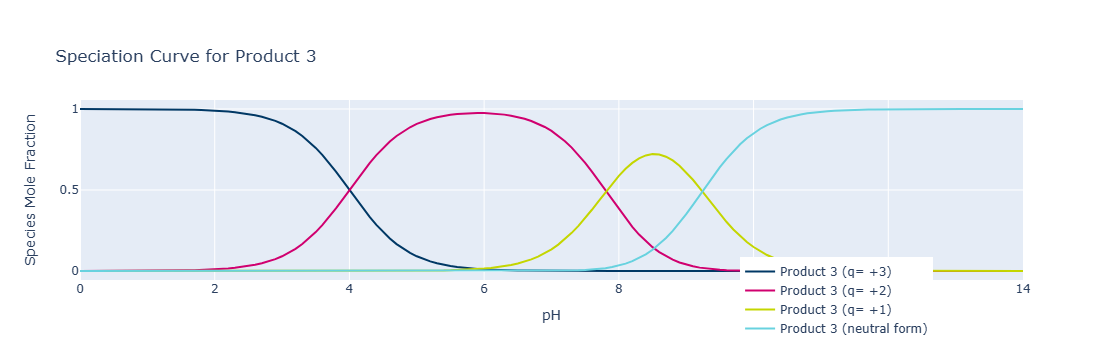

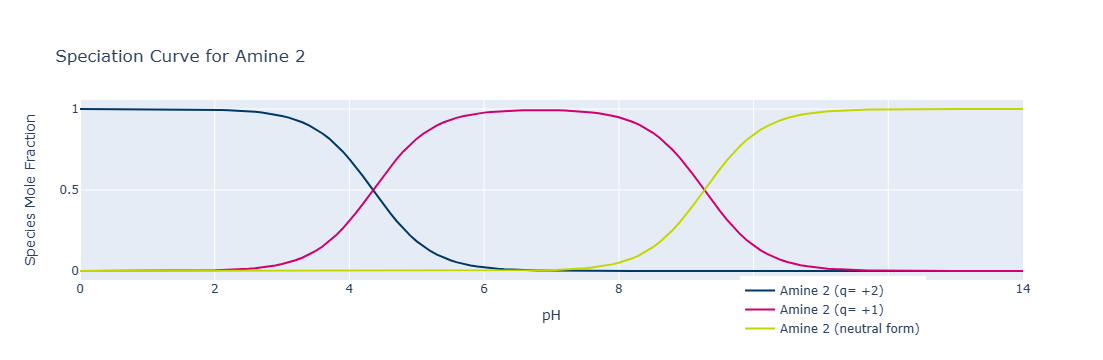

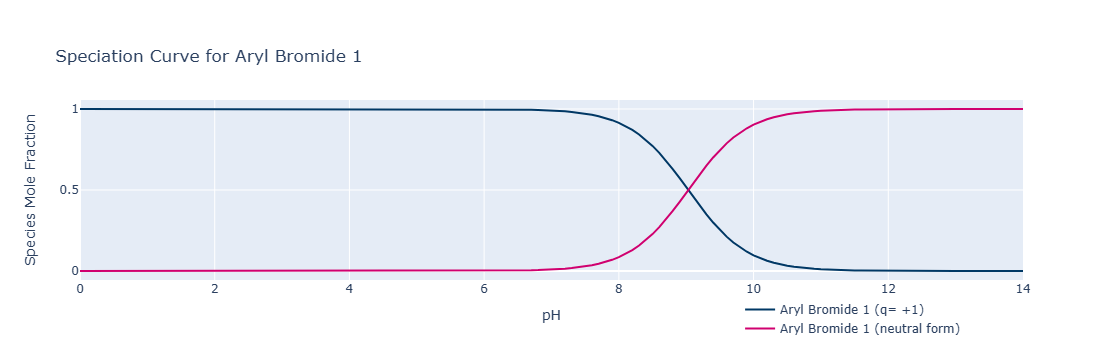

In [23]:
# generate speciation curves
for compound in compounds_panel_values.values():
    if compound.get('Isolate'):
        fig_1 = PlotSpecies(compound)
        display(fig_1)

    elif compound.get('Impurity'):
        fig_1 = PlotSpecies(compound)
        display(fig_1)

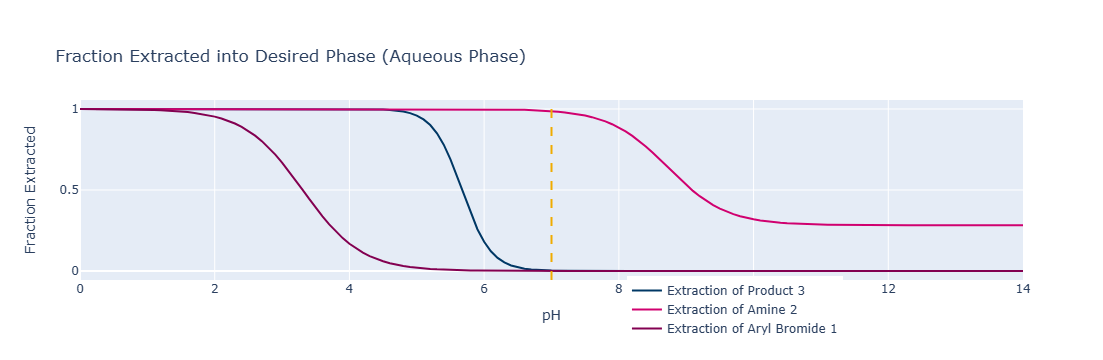

In [24]:
# generate and plot fraction extracted curves
fig2 = PlotFractionExtracted(compounds_panel_values, system_panel_values)
display(fig2)

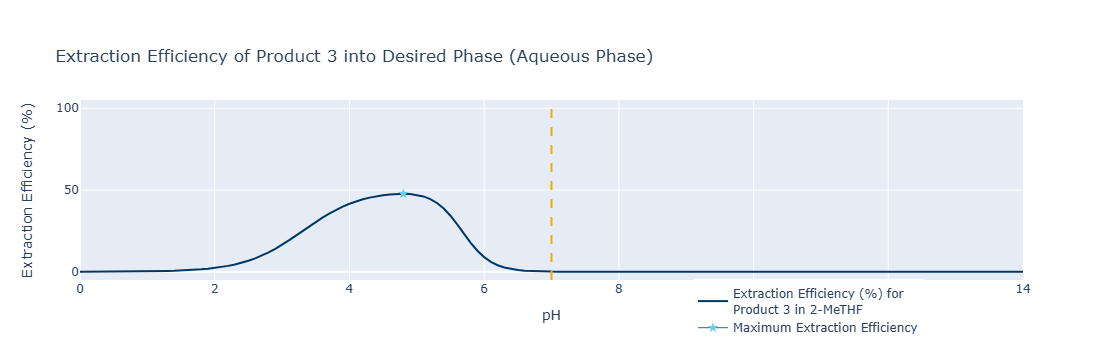

In [27]:
# generate and plot extraction efficiency
fig3 = PlotExtractionEfficiency(compounds_panel_values, system_panel_values)
display(fig3)

### Generate Results

In [28]:
# Calculate extractions
_, results = CalculateExhaustiveExtractions(solvents, compounds_panel_values, system_panel_values)

In [29]:
results.head()

,pH,Solvent,Product 3_logP,Amine 2_logP,Aryl Bromide 1_logP,Extraction_eff_Product 3_aq,Fraction_extracted_Product 3_aq,Fraction_extracted_Amine 2_aq,Fraction_extracted_Aryl Bromide 1_aq,Volume_ratio
0,0.0,"1,1,1-Trichloroethane",6.083062,-0.705796,6.639175,0.202480,1.0,1.0,0.995950,1.0
1,0.1,"1,1,1-Trichloroethane",6.083062,-0.705796,6.639175,0.254640,1.0,1.0,0.994907,1.0
2,0.2,"1,1,1-Trichloroethane",6.083062,-0.705796,6.639175,0.320151,1.0,1.0,0.993597,1.0
3,0.3,"1,1,1-Trichloroethane",6.083062,-0.705796,6.639175,0.402379,1.0,1.0,0.991952,1.0
4,0.4,"1,1,1-Trichloroethane",6.083062,-0.705796,6.639175,0.505512,1.0,1.0,0.989890,1.0


In [30]:
results.shape

(24252, 10)

In [61]:
# The same can be done looking at different volume ratios and calculating maximum extraction efficiency at each volume ratio:
# Define Valume Ratio limits
volume_ratios = (0.1, 5.0)

_, vr_results = CalculateExtractions(solvents, compounds_panel_values, system_panel_values, volume_ratios)

In [62]:
vr_results.head()

,Product 3_logP,Amine 2_logP,Aryl Bromide 1_logP,Max_eff_pH,Max_ext_eff,PRODUCT 3_fraction_org,AMINE 2_fraction_org,ARYL BROMIDE 1_fraction_org,Volume_ratio
"1,1,1-Trichloroethane",6.083062,-0.705796,6.639175,5.0,48.326346,0.990299,8.638695e-07,0.975994,0.1
"1,1-Dichloroethane",6.417474,-0.202966,6.693888,4.9,48.044607,0.987121,2.085380e-06,0.973427,0.1
"1,1-Dichloroethene",6.544878,-0.476505,7.012580,4.8,48.666290,0.989383,8.348416e-07,0.983769,0.1
"1,2-Dichlorobenzene",5.912347,-0.879814,6.725937,5.1,48.692852,0.989438,7.569705e-07,0.984252,0.1
"1,2-Dichloroethane",6.303173,-0.180649,6.589213,5.0,47.878858,0.983998,2.894641e-06,0.973146,0.1


In [63]:
vr_results.shape

(2064, 9)